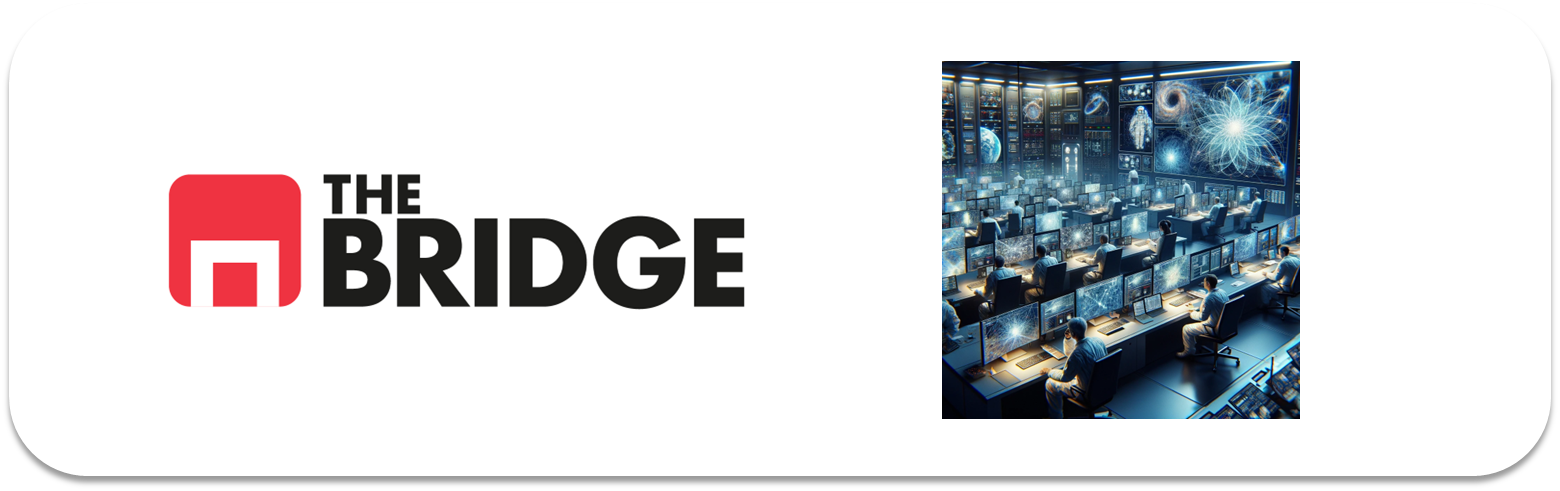

## PRACTICA OBLIGATORIA: **Redes Convolucionales**

* La práctica obligatoria de esta unidad consiste en un ejercicio de construcción de una red convolucional con Keras para la clasificación de imagenes de simpáticos perretes y gatetes. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import keras
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

### Problema de Negocio y dataset

Una conocida empresa de información inmobiliaria utiliza un CAPTCHA visual de perros y gatos para detectar webscrappings intensivos y ataques de denegación de servicio. Últimamente, ha detectado que su sistema está empezando a flojear, es decir que hay muchos sistemas de detección automática de imágenes que son capaces de detectar que es un perro y un gato y salterse el CAPTCHA antirobots. Por eso nos ha pedido que entrenemos un modelo potente de clasificación que emule a estos sistemas con el objetivo de emplear como fotografías para el CAPTCHA aquellas que no sepa detectar este sistema emulador de chicos malos.  

Pues manos a la obra, tenemos que seleccionar en un conjunto de 1000 imágenes aquellas que peor se le daría clasificar a un potencial sistema anti-CAPTCHA.  

Para ello vamos a emplear un conjunto de train de 4000 imágenes de perretes y gatetes que se encuentran distribuidas en "data" en cuatro directorios "github_train_0",  "github_train_1", "githun_train_2" y "github_train_3". Los datos de las imagenes que tenemos que clasificar y luego seleccionar como las más "difíciles" están en "data" en el directorio "github_test".


### Se pide

1. Crear los datasets X,y de train y test, leyendo las imágenes de los directorios correspondientes (tendrás que leer todas las imágenes de los cuatro directorios para train) y a la vez que se leen adpatar su resolución para que todas tengan un tamaño de 32x32. En este caso puedes adaptar las funciones de los ejercicios de la unidad. NOTA: Ten en cuenta que la clase a la que pertenece en la foto está en el nombre del archivo.

2. Crea un modelo DL basado en redes convolucionales con al menos dos juegos Convolucional-Pooling. Sigue todo el proceso de ML (visualización del dataset, MiniEDA, Construcción del modelo)

3. Entrenar el modelo con un callback de Earlystopping con paciencia la que tengas :-). Muestra su historial de entrenamiento.

4. Evalua el modelo, haz un reporte de clasificacion y muestra la matriz de confianza.

5. Es el momento de seleccionar las imagenes: Selecciona el 10% de imágenes mal clasificadas de una y otra clase que tengan el mayor nivel de confianza de que pertenencían a la clase errónea. Es decir las imágenes de perros clasificadas como gatos y con la probabilidad de ser perror más alta.


### Extra (para hacer en clase)

Repite los pasos 3 a 5 utilizando el generador de imágenes sintéticas o Image Augmentation de Keras. 



### 1. Crear datasets de train y test

In [2]:
# Función para cargar imágenes desde un directorio y redimensionarlas
def load_images_from_folder(folder, size = (32, 32)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img)
            # La clase está indicada en el nombre del archivo
            label = 1 if "dog" in filename else 0  # 1 para perro, 0 para gato
            labels.append(label)
    return images, labels

# Directorios de entrenamiento
train_directories = ["data/github_train_0", "data/github_train_1", 
                     "data/github_train_2", "data/github_train_3"]

# Cargar imágenes de entrenamiento
X_train = []
y_train = []

for directory in train_directories:
    images, labels = load_images_from_folder(directory)
    X_train.extend(images)
    y_train.extend(labels)

# Convertir a numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

# Directorio de prueba
test_directory = "data/github_test"
X_test, y_test = load_images_from_folder(test_directory)

# Convertir a numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

### 2. Crear modelo DL

In [3]:
X_train = X_train / 255
X_test = X_test / 255

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

In [5]:
print("Dimensiones de X_train:", X_train.shape)
print("Dimensiones de X_val:", X_val.shape)
print("Dimensiones de X_test:", X_test.shape)

Dimensiones de X_train: (3200, 32, 32, 3)
Dimensiones de X_val: (800, 32, 32, 3)
Dimensiones de X_test: (1000, 32, 32, 3)


In [6]:
def show_images_batch(images, labels = None, n_cols = 5, size_scale = 2):
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize = (n_cols * size_scale, n_rows * 1.1 * size_scale))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap = "Greys")
        plt.axis("off")
        if labels is not None:
            title = "Perro" if labels[index] == 1 else "Gato"
            plt.title(title)

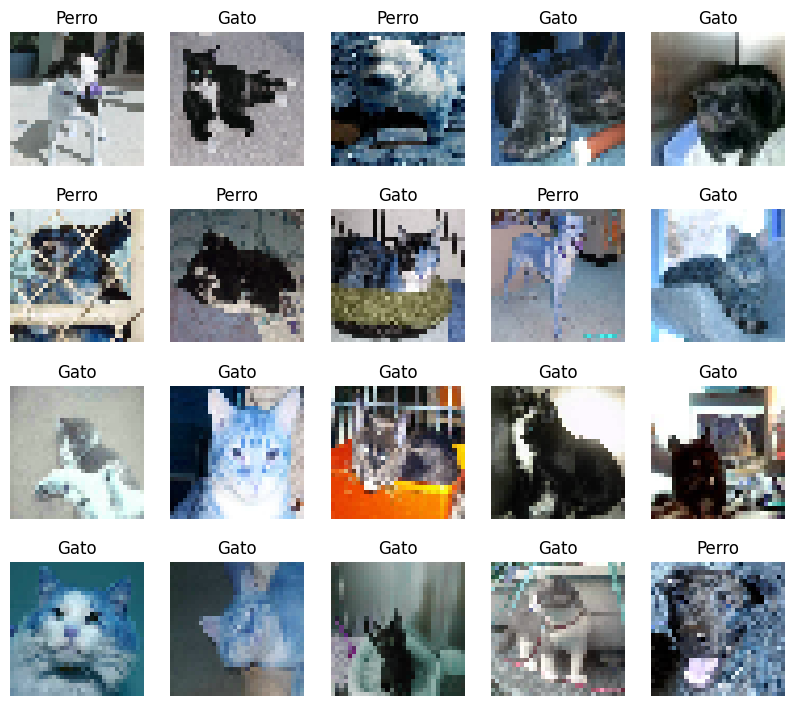

In [7]:
show_images_batch(X_train[:20], y_train[:20])

In [8]:
capas = [keras.layers.Conv2D(filters = 32, kernel_size = (3, 3),
                            input_shape = (X_train[0].shape), 
                            padding = "same",
                            activation = "relu"),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos otra capa de convolución y pooling
         keras.layers.Conv2D(filters = 64, 
                             kernel_size = (3, 3),
                             padding = "same", 
                             activation = "relu"),
         keras.layers.MaxPooling2D(pool_size = (2, 2)),

# Añadimos una capa de flatten para convertir la salida de la capa de pooling en un vector
         keras.layers.Flatten(),

# Añadimos una capa densas para la clasificación 
         keras.layers.Dense(units = 64, activation = "relu"),

# Añadimos el dropout
        keras.layers.Dropout(0.5),

# Añadimos la capa de salida con 1 neurona, una por cada clase
         keras.layers.Dense(1, activation = "sigmoid")]

# Creamos el modelo
model = keras.Sequential(capas)

### 3. Entrenar modelo

In [9]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [10]:
early_stopping = EarlyStopping(monitor = "val_loss", patience = 5)

In [11]:
history = model.fit(X_train,
                    y_train,
                    epochs = 20,
                    batch_size = 32,
                    validation_data = (X_val, y_val),
                    callbacks = [early_stopping])

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5223 - loss: 0.6958 - val_accuracy: 0.6775 - val_loss: 0.6582
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6157 - loss: 0.6550 - val_accuracy: 0.6112 - val_loss: 0.6400
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6664 - loss: 0.6075 - val_accuracy: 0.7113 - val_loss: 0.5665
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6964 - loss: 0.5780 - val_accuracy: 0.7063 - val_loss: 0.5520
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7313 - loss: 0.5526 - val_accuracy: 0.7387 - val_loss: 0.5205
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7350 - loss: 0.5360 - val_accuracy: 0.7300 - val_loss: 0.5260
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7516 - loss: 0.5124 - val_accuracy: 0.7600 - val_loss: 0.4936
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7792 - loss: 0.4624 - val_accuracy: 0.

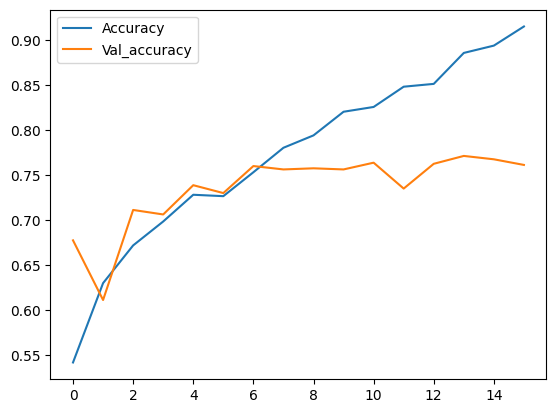

In [12]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df["accuracy"], label = "Accuracy")
plt.plot(history_df["val_accuracy"], label = "Val_accuracy")
plt.legend();

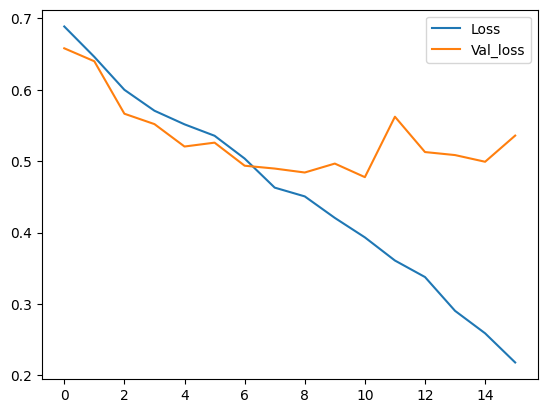

In [13]:
plt.plot(history_df["loss"], label = "Loss")
plt.plot(history_df["val_loss"], label = "Val_loss")
plt.legend();

### 4. Evaluar modelo

In [14]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.77      0.76       500
           1       0.76      0.74      0.75       500

    accuracy                           0.76      1000
   macro avg       0.76      0.76      0.76      1000
weighted avg       0.76      0.76      0.76      1000



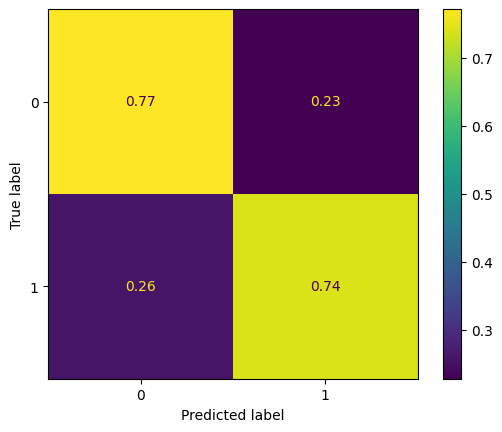

In [16]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize = "true");

### 5. Seleccionar imágenes mal clasificadas

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


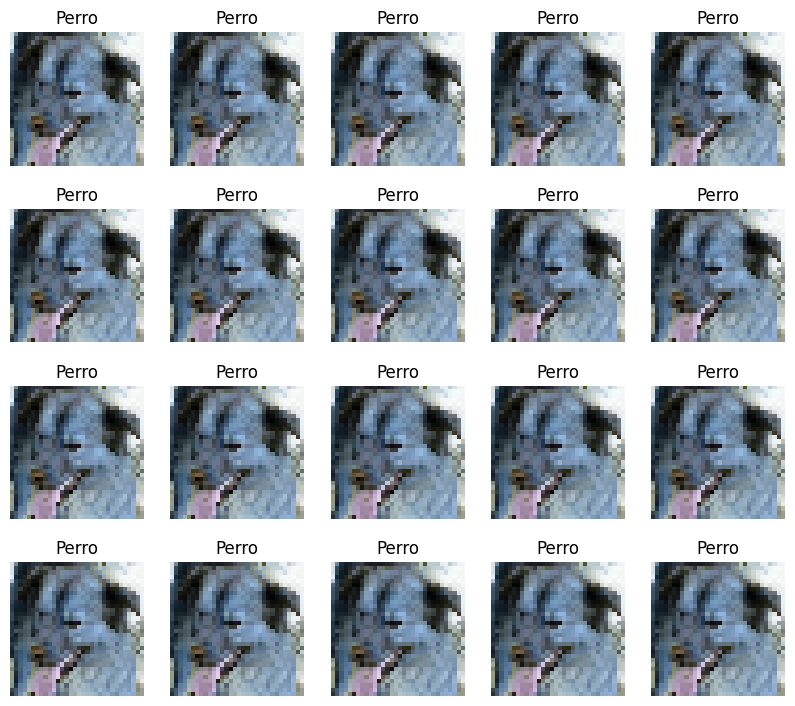

In [17]:
# Obtener las probabilidades de predicción para todas las imágenes
y_pred_probs = model.predict(X_test)

# Identificar las imágenes mal clasificadas con mayor certeza
misclassified_indices = np.where(y_pred != y_test)[0]
misclassified_probs = y_pred_probs[misclassified_indices]

# Ordenar por probabilidad de la clase incorrecta (pero alta)
sorted_indices = np.argsort(misclassified_probs[:, 0])

# Seleccionar el 10% de las imágenes más difíciles (5% de cada clase)
n_samples = int(len(misclassified_indices) * 0.05)
difficult_indices = misclassified_indices[sorted_indices[-n_samples:]]

# Ejemplo de cómo acceder a las imágenes seleccionadas
difficult_images = X_test[difficult_indices]
difficult_labels = y_test[difficult_indices]

# Mostrar las imágenes mal clasificadas más difíciles
show_images_batch(difficult_images[:20], difficult_labels[:20])